28.867513459481287


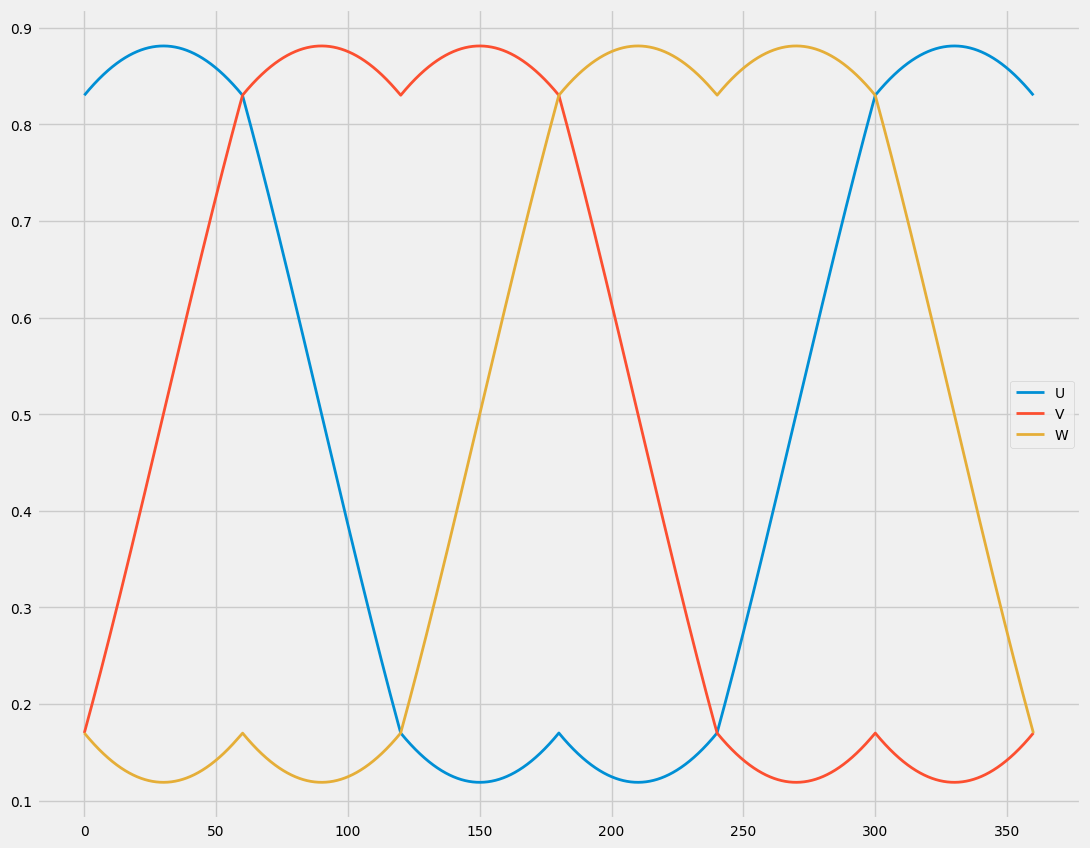

In [1]:
'''
1325
házikó
'''
def ftri(x, p, a):
    return 4 * a / p * np.abs((x -p / 4) % p  - p/ 2) -a

import numpy as np
import matplotlib.pyplot as plt

plt.style.use(['default', 'fivethirtyeight'])
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 10

f_out = 50.0
f_pwm = 10.0e3
f_update = 500.0
Vdc = 50.0
Vm = 22
Vmmax = np.sqrt(3)/3.0 * Vdc
print(Vmmax)

dt = 1 / f_pwm * 0.2
tstop = 40e-3
t = 0.0

T_out = 1.0 / f_out
T_pwm = 1.0 / f_pwm
T_update = 1.0 / f_update

MClark = 2 / 3 * np.array([
    [1, -0.5, -0.5],
    [0, np.sqrt(3) / 2, -np.sqrt(3) / 2],
])

Ml2n = Vdc / 3 * np.array([
    [2, -1, -1],
    [-1, 2, -1],
    [-1, -1, 2]
])


Vi= np.array([
    [0, 0],
    [-1.0/3.0, -np.sqrt(3) / 3.0],
    [-1.0/3.0, np.sqrt(3) / 3.0],
    [-2.0 / 3.0, 0.0],
    [2.0 / 3.0, 0.0],
    [1.0 / 3.0, -np.sqrt(3) / 3.0],
    [1.0 / 3.0, np.sqrt(3) / 3.0],
    [0, 0]
]) * Vdc

swt = np.array([[0,0,0,0,1,1,1,1], [0,0,1,1,0,0,1,1], [0,1,0,1,0,1,0,1]]).T


# VREF 
theta = np.linspace(0, 360, 5001)
dcs = np.zeros((3, theta.shape[0]))
for i, theta_i in enumerate(theta):
    Vref = np.array([Vm * np.cos(np.deg2rad(theta_i)), Vm *np.sin(np.deg2rad(theta_i))])
    #plt.plot([0, Vref[0]], [0, Vref[1]], c="C8", linestyle="solid", marker='h', label=r'V$_{ref}$');

    s = 0
    Vl = np.array([])
    Vr = np.array([])
    swl = np.array([])
    swr = np.array([])

    if theta_i >=0 and theta_i <=60:
        s = 1
        Vl = Vi[6].copy()
        Vr = Vi[4].copy()
        swl = swt[6].copy()
        swr = swt[4].copy()
    elif theta_i >=60 and theta_i <=120:
        s = 2
        Vl = Vi[2].copy()
        Vr = Vi[6].copy()
        swl = swt[2].copy()
        swr = swt[6].copy()
    elif theta_i >=120 and theta_i <=180:
        s = 3
        Vl = Vi[3].copy()
        Vr = Vi[2].copy()
        swl = swt[3].copy()
        swr = swt[2].copy()
    elif theta_i >=180 and theta_i <=240:
        s = 4
        Vl = Vi[1].copy()
        Vr = Vi[3].copy()
        swl = swt[1].copy()
        swr = swt[3].copy()
    elif theta_i >=240 and theta_i <=300:
        s = 5
        Vl = Vi[5].copy()
        Vr = Vi[1].copy()
        swl = swt[5].copy()
        swr = swt[1].copy()
    else:
        s=6
        Vl = Vi[4].copy()
        Vr = Vi[5].copy()
        swl = swt[4].copy()
        swr = swt[5].copy()


    A = np.array([Vl, Vr]).T
    b = T_update * Vref.copy()
    T = np.linalg.solve(A, b)
    Toff = T_update - T[0] - T[1]
    #plt.plot([0, T[0]/T_update*Vl[0]], [0, T[0]/T_update*Vl[1]], c="darkviolet")
    #plt.plot([0, T[1]/T_update*Vr[0]], [0, T[1]/T_update*Vr[1]], c="darkviolet")

    dc = 1/T_update * (np.dot(np.array([swl, swr]).T, T) + Toff/2)
    dcs[:, i] = dc.copy()

plt.figure(figsize=(12, 10))
plt.plot(theta, dcs[0])
plt.plot(theta, dcs[1])
plt.plot(theta, dcs[2]);
plt.legend(["U", "V", "W"]);
plt.grid('both')

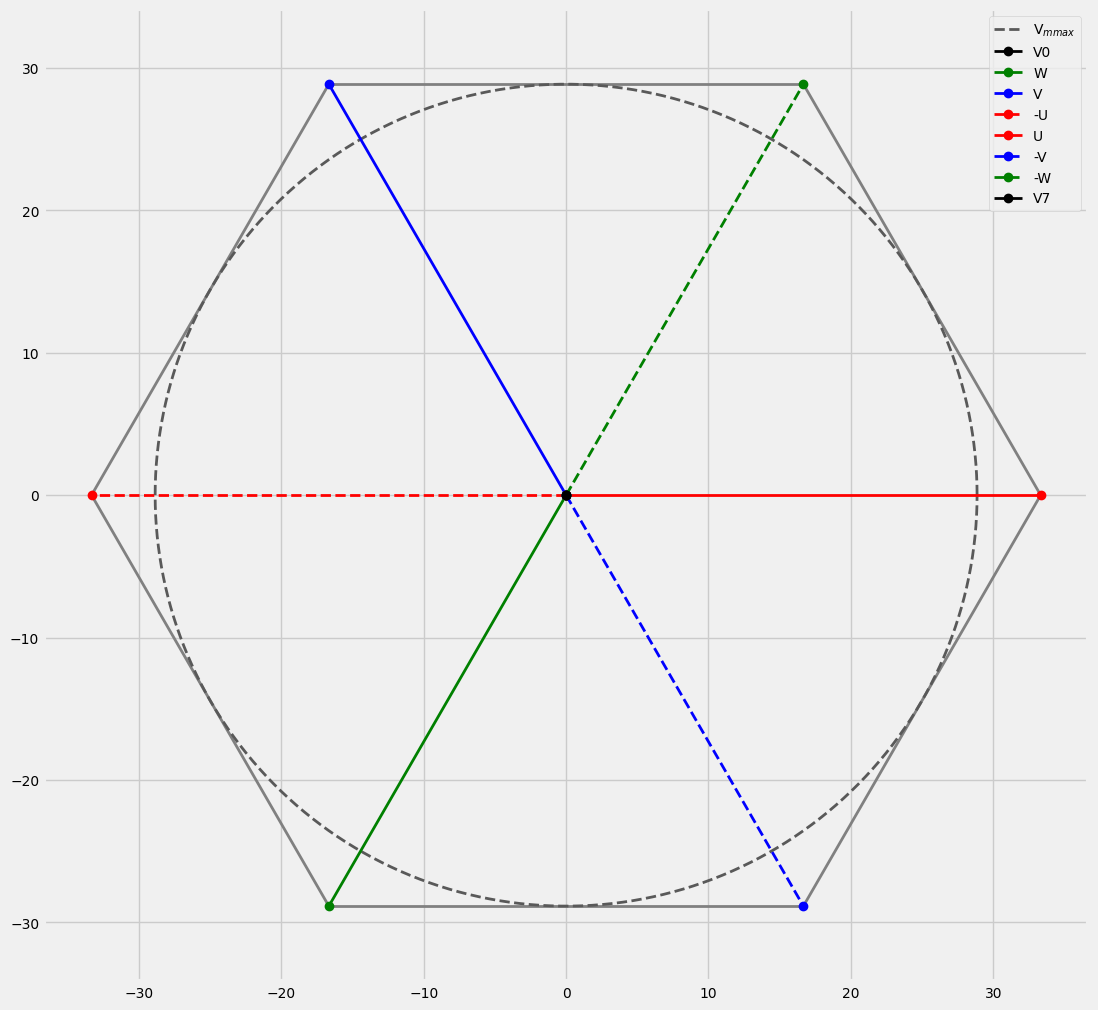

In [2]:
plt.figure(figsize=(12, 12))
plt.plot([Vi[4][0], Vi[6][0]], [Vi[4][1], Vi[6][1]], color="0.5")
plt.plot([Vi[6][0], Vi[2][0]], [Vi[6][1], Vi[2][1]], color="0.5")
plt.plot([Vi[2][0], Vi[3][0]], [Vi[2][1], Vi[3][1]], color="0.5")
plt.plot([Vi[3][0], Vi[1][0]], [Vi[3][1], Vi[1][1]], color="0.5")
plt.plot([Vi[1][0], Vi[5][0]], [Vi[1][1], Vi[5][1]], color="0.5")
plt.plot([Vi[5][0], Vi[4][0]], [Vi[5][1], Vi[4][1]], color="0.5")
theta = np.linspace(0, 2 * np.pi, 1001)
plt.plot(Vmmax * np.cos(theta), Vmmax * np.sin(theta), color="0.35", linestyle="--", label=r"V$_{mmax}$")



colors = ['k', 'g', 'b', 'r', 'r', 'b', 'g', 'k']
lstyles = ['-','-','-','--','-','--','--','-']
legends=["V0","W", "V", "-U", "U", "-V", "-W", "V7"]
for i, vi in enumerate(Vi):
    plt.plot([0, vi[0]], [0, vi[1]], marker='o', c=colors[i], linestyle=lstyles[i], label=legends[i])

plt.legend();
plt.axis('equal');

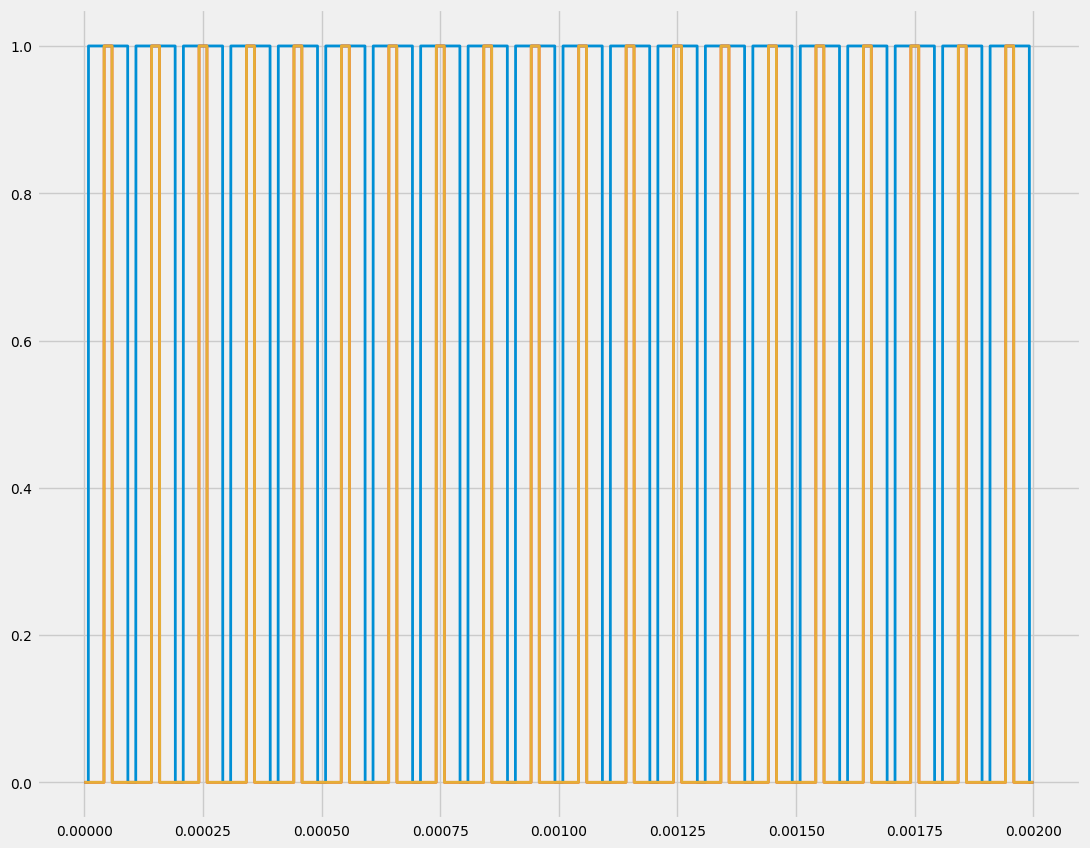

In [3]:
t = np.linspace(0, T_update, 10001)
Vpwm = np.zeros((t.shape[0], 3)).T

for i, ti in enumerate(t):
    vtri = (0.5 + 0.5 * ftri(ti+T_pwm/4, T_pwm, 1))
    if dc[0] >= vtri:
        Vpwm[0, i] = 1.0
        
    if dc[1] >= vtri:
        Vpwm[1, i] = 1.0
        
    if dc[2] >= vtri:
        Vpwm[2, i] = 1.0
    
plt.figure(figsize=(12, 10))
plt.plot(t, Vpwm[0])
plt.plot(t, Vpwm[1])
plt.plot(t, Vpwm[2]);

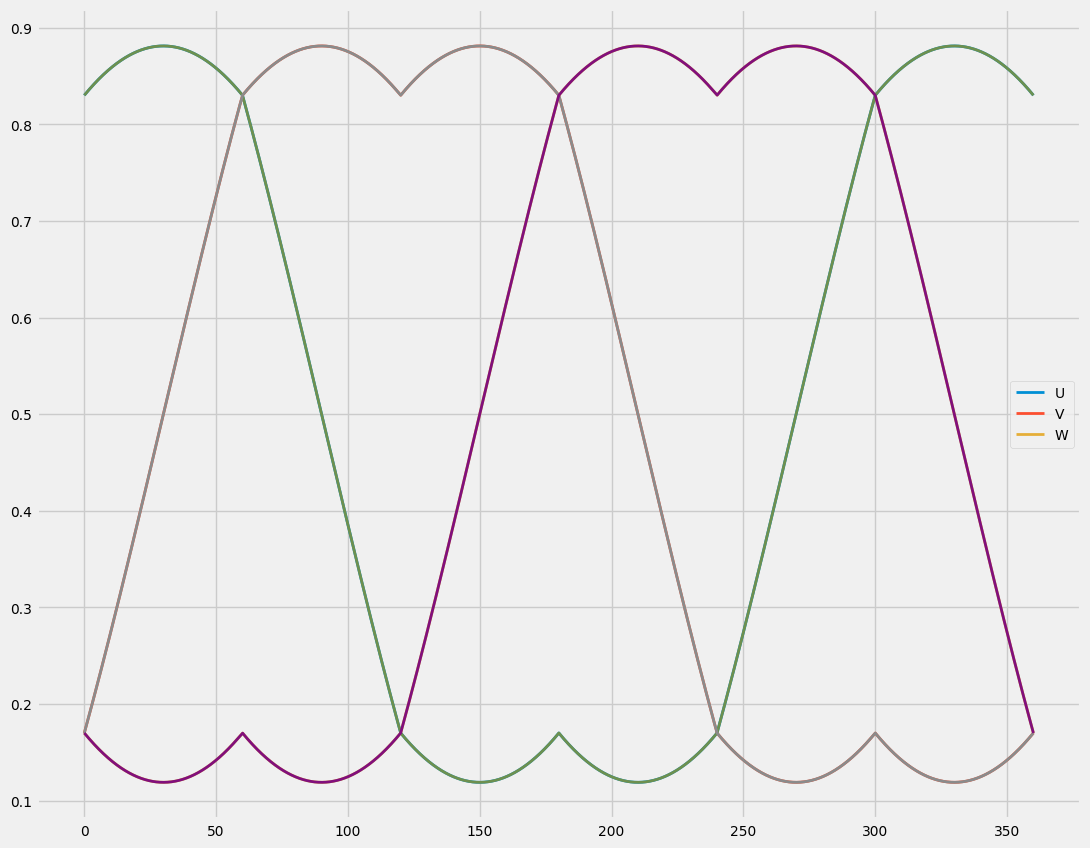

In [6]:
from svpwm import SVPWM


pwm1 = SVPWM(50.0, 1/500.0)

theta = np.linspace(0, 360, 5001)
dcs = np.zeros((3, theta.shape[0]))
for i, theta_i in enumerate(theta):
    Vref = np.array([Vm * np.cos(np.deg2rad(theta_i)), Vm *np.sin(np.deg2rad(theta_i))])
    dcs[:, i] = pwm1.getDC(Vref)

plt.figure(figsize=(12, 10))
plt.plot(theta, dcs[0])
plt.plot(theta, dcs[1])
plt.plot(theta, dcs[2]);

pwm1 = SVPWM(50.0, 1/250.0)
for i, theta_i in enumerate(theta):
    Vref = np.array([Vm * np.cos(np.deg2rad(theta_i)), Vm *np.sin(np.deg2rad(theta_i))])
    dcs[:, i] = pwm1.getDC(Vref)

plt.plot(theta, dcs[0])
plt.plot(theta, dcs[1])
plt.plot(theta, dcs[2]);

plt.legend(["U", "V", "W"]);
plt.grid('both')